# Introduction to Count Data Models: Poisson Regression

## Learning Objectives

- Understand why OLS is inappropriate for count data
- Learn the Poisson distribution and its assumptions
- Estimate Poisson regression models using PanelBox
- Interpret coefficients as Incidence Rate Ratios (IRR)
- Assess model fit and diagnose overdispersion

## Duration
60-75 minutes

## Prerequisites
- Linear regression (OLS)
- Basic maximum likelihood concepts
- Probability distributions

## Dataset
Healthcare utilization: doctor visits by individuals
- N = 2,000
- Outcome: number of doctor visits (count)
- Predictors: age, income, insurance coverage, chronic condition

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries
from scipy import stats
from scipy.special import factorial

# PanelBox imports - PooledPoisson for cross-sectional Poisson regression
import statsmodels.api as sm
from panelbox.models.count import PooledPoisson

# Visualization configuration
plt.style.use('seaborn-v0_8-whitegrid')  # Clean white grid background
sns.set_palette('husl')  # Perceptually uniform, colorblind-friendly palette
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Set random seed for reproducibility
np.random.seed(42)

# Define paths (relative to notebook location in examples/count/notebooks/)
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data'
OUTPUT_DIR = BASE_DIR / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures' / '01_poisson'
TABLES_DIR = OUTPUT_DIR / 'tables' / '01_poisson'

# Create output directories if they don't exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

print('Setup complete!')
print(f'Data directory: {DATA_DIR}')
print(f'Output directory: {OUTPUT_DIR}')

Setup complete!
Data directory: ../data
Output directory: ../outputs


In [2]:
# Load healthcare visits data (2,000 individuals with doctor visit counts)
df = pd.read_csv(DATA_DIR / 'healthcare_visits.csv')

# Preview dataset structure and content
print('Dataset shape:', df.shape)
print('\nFirst few rows:')
display(df.head(10))

# Check variable types (visits should be integer, insurance/chronic binary)
print('\nVariable types:')
print(df.dtypes)

# Summary statistics to understand distributions
print('\nBasic summary statistics:')
display(df.describe())

Dataset shape: (2000, 6)

First few rows:


,individual_id,visits,age,income,insurance,chronic
0,1,4,53,26.9745,1,0
1,2,4,42,37.0878,1,0
2,3,5,56,25.1422,0,0
3,4,9,72,33.6234,1,0
4,5,8,40,12.9855,1,0
5,6,1,40,45.9694,1,0
6,7,5,73,40.4766,1,0
7,8,19,58,24.7728,1,1
8,9,2,36,60.0722,1,0
9,10,4,54,70.9902,1,1



Variable types:
individual_id      int64
visits             int64
age                int64
income           float64
insurance          int64
chronic            int64
dtype: object

Basic summary statistics:


,individual_id,visits,age,income,insurance,chronic
count,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000
mean,1000.5000,6.2930,45.6990,47.7515,0.7765,0.2850
std,577.4946,4.4439,16.6459,29.1495,0.4167,0.4515
min,1.0000,0.0000,18.0000,10.0000,0.0000,0.0000
25%,500.7500,3.0000,33.0000,26.4307,1.0000,0.0000
50%,1000.5000,5.0000,45.0000,40.4460,1.0000,0.0000
75%,1500.2500,8.0000,57.0000,60.2996,1.0000,1.0000
max,2000.0000,25.0000,85.0000,150.0000,1.0000,1.0000


## 1. Why OLS is Inappropriate for Count Data

Count data has special characteristics that violate OLS assumptions:

### Characteristics of Count Data
1. **Discrete**: Only non-negative integers (0, 1, 2, 3, ...)
2. **Bounded below**: Cannot be negative
3. **Often skewed**: Typically right-skewed distribution
4. **Heteroskedastic**: Variance increases with the mean

### Problems with OLS
1. **Predicts negative values**: OLS can predict impossible negative counts
2. **Ignores discreteness**: Treats counts as continuous
3. **Inefficient**: Doesn't account for variance structure
4. **Invalid inference**: Standard errors are incorrect

Let's demonstrate these problems empirically.

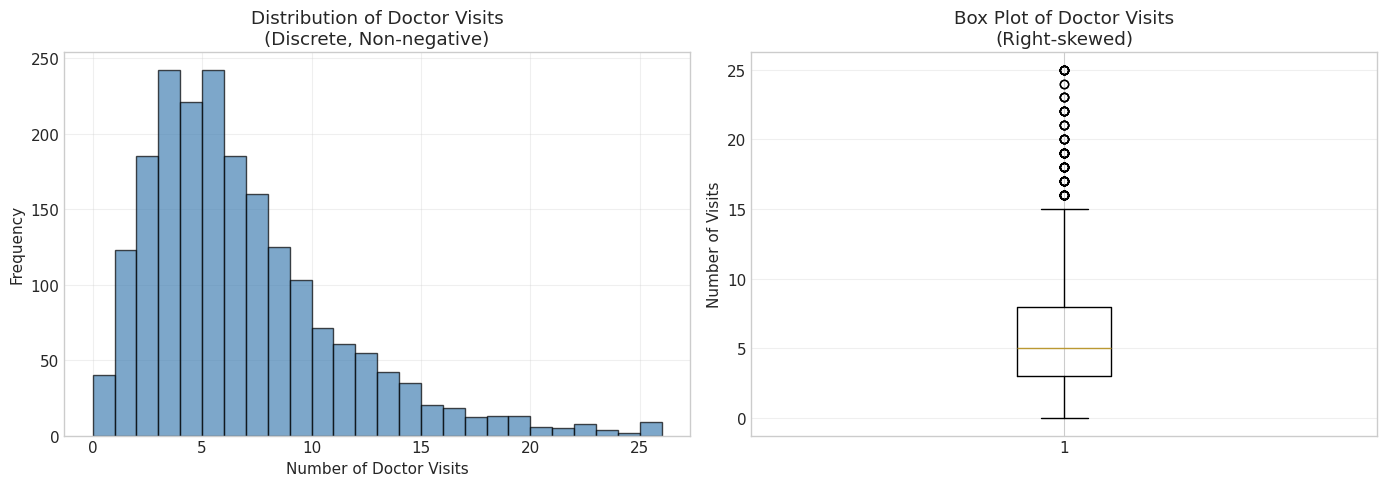

Mean visits: 6.29
Variance: 19.75
Variance/Mean ratio: 3.14
Proportion of zeros: 2.00%
Range: 0 to 25


In [3]:
# Visualize the distribution of the count outcome variable
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: histogram showing discrete nature of counts
axes[0].hist(df['visits'], bins=range(0, df['visits'].max() + 2),
             alpha=0.7, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Number of Doctor Visits')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Doctor Visits\n(Discrete, Non-negative)')
axes[0].grid(alpha=0.3)

# Right panel: boxplot revealing skewness and outliers
axes[1].boxplot(df['visits'], vert=True)
axes[1].set_ylabel('Number of Visits')
axes[1].set_title('Box Plot of Doctor Visits\n(Right-skewed)')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'distribution_visits.png', dpi=300, bbox_inches='tight')
plt.show()

# Key distributional statistics for count data
print(f'Mean visits: {df["visits"].mean():.2f}')
print(f'Variance: {df["visits"].var():.2f}')
print(f'Variance/Mean ratio: {df["visits"].var() / df["visits"].mean():.2f}')
print(f'Proportion of zeros: {(df["visits"] == 0).mean():.2%}')
print(f'Range: {df["visits"].min()} to {df["visits"].max()}')

*Figure: Left panel shows a histogram of doctor visits (count data), exhibiting a right-skewed distribution with most values concentrated between 0-10 visits. Right panel shows a boxplot confirming the positive skew with several high outliers. The variance-to-mean ratio exceeds 1, hinting at overdispersion.*

OLS Problems Demonstration:
Number of negative predictions: 20
Minimum prediction: -1.33
Maximum prediction: 15.34

Fraction of predictions < 0: 1.00%
Fraction of predictions non-integer: 100% (all predictions are continuous)


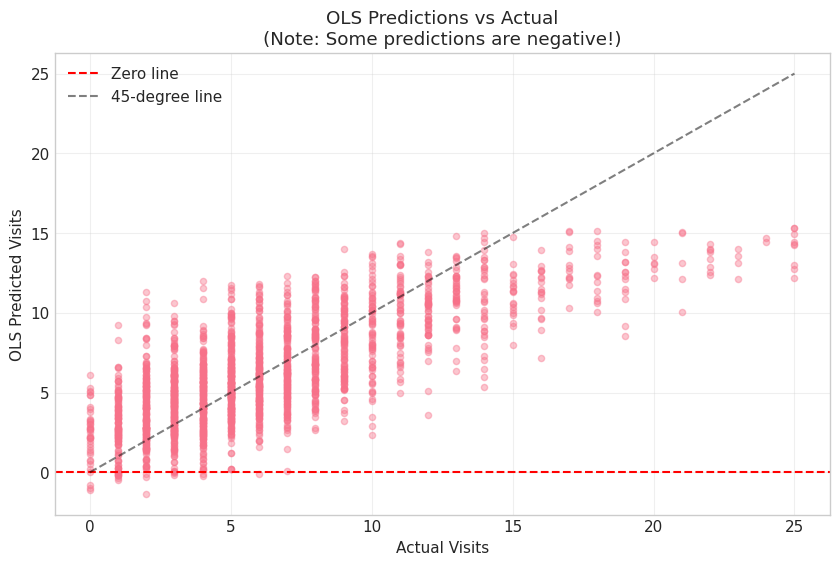

In [4]:
from sklearn.linear_model import LinearRegression

# Prepare features and outcome for OLS comparison
X_ols = df[['age', 'income', 'insurance', 'chronic']].values
y_ols = df['visits'].values

# Fit OLS linear regression (inappropriate for count data)
ols_model = LinearRegression()
ols_model.fit(X_ols, y_ols)

# Generate OLS predictions to demonstrate problems
y_pred_ols = ols_model.predict(X_ols)

# Show concrete evidence of OLS shortcomings
print('OLS Problems Demonstration:')
print('=' * 50)
print(f'Number of negative predictions: {(y_pred_ols < 0).sum()}')
print(f'Minimum prediction: {y_pred_ols.min():.2f}')
print(f'Maximum prediction: {y_pred_ols.max():.2f}')
print(f'\nFraction of predictions < 0: {(y_pred_ols < 0).mean():.2%}')
print(f'Fraction of predictions non-integer: 100% (all predictions are continuous)')

# Scatter plot: OLS predicted vs actual counts
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_ols, y_pred_ols, alpha=0.4, s=20)
ax.axhline(y=0, color='red', linestyle='--', label='Zero line')  # Impossible region below
ax.plot([0, y_ols.max()], [0, y_ols.max()], 'k--', alpha=0.5, label='45-degree line')
ax.set_xlabel('Actual Visits')
ax.set_ylabel('OLS Predicted Visits')
ax.set_title('OLS Predictions vs Actual\n(Note: Some predictions are negative!)')
ax.legend()
ax.grid(alpha=0.3)
plt.savefig(FIGURES_DIR / 'ols_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

*Figure: Scatter plot of OLS predicted visits vs actual visits. Points below the red zero line represent impossible negative predictions generated by OLS, demonstrating why linear regression is inappropriate for count data. The 45-degree line shows the ideal prediction target.*

## 2. The Poisson Distribution

### Definition

The Poisson distribution models count data with a single parameter $\lambda$ (lambda):

$$P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, 3, \ldots$$

Where:
- $\lambda > 0$ is the rate parameter
- $k$ is the count (0, 1, 2, ...)
- $e \approx 2.718$ (Euler's number)

This formula is known as the **PMF (Probability Mass Function)** -- the discrete analogue of a probability density function, giving the probability that the random variable takes each possible integer value.

### Key Properties

1. **Mean**: $E[Y] = \lambda$
2. **Variance**: $Var[Y] = \lambda$
3. **Equidispersion**: Mean equals variance (critical assumption!)
4. **Domain**: Non-negative integers only
5. **Shape**: Skewed right for small $\lambda$, approaches normal for large $\lambda$

### When to Use

- Modeling counts: events, occurrences, incidents
- Rate data: events per unit of time/space
- Examples: doctor visits, patent counts, crime incidents, website clicks

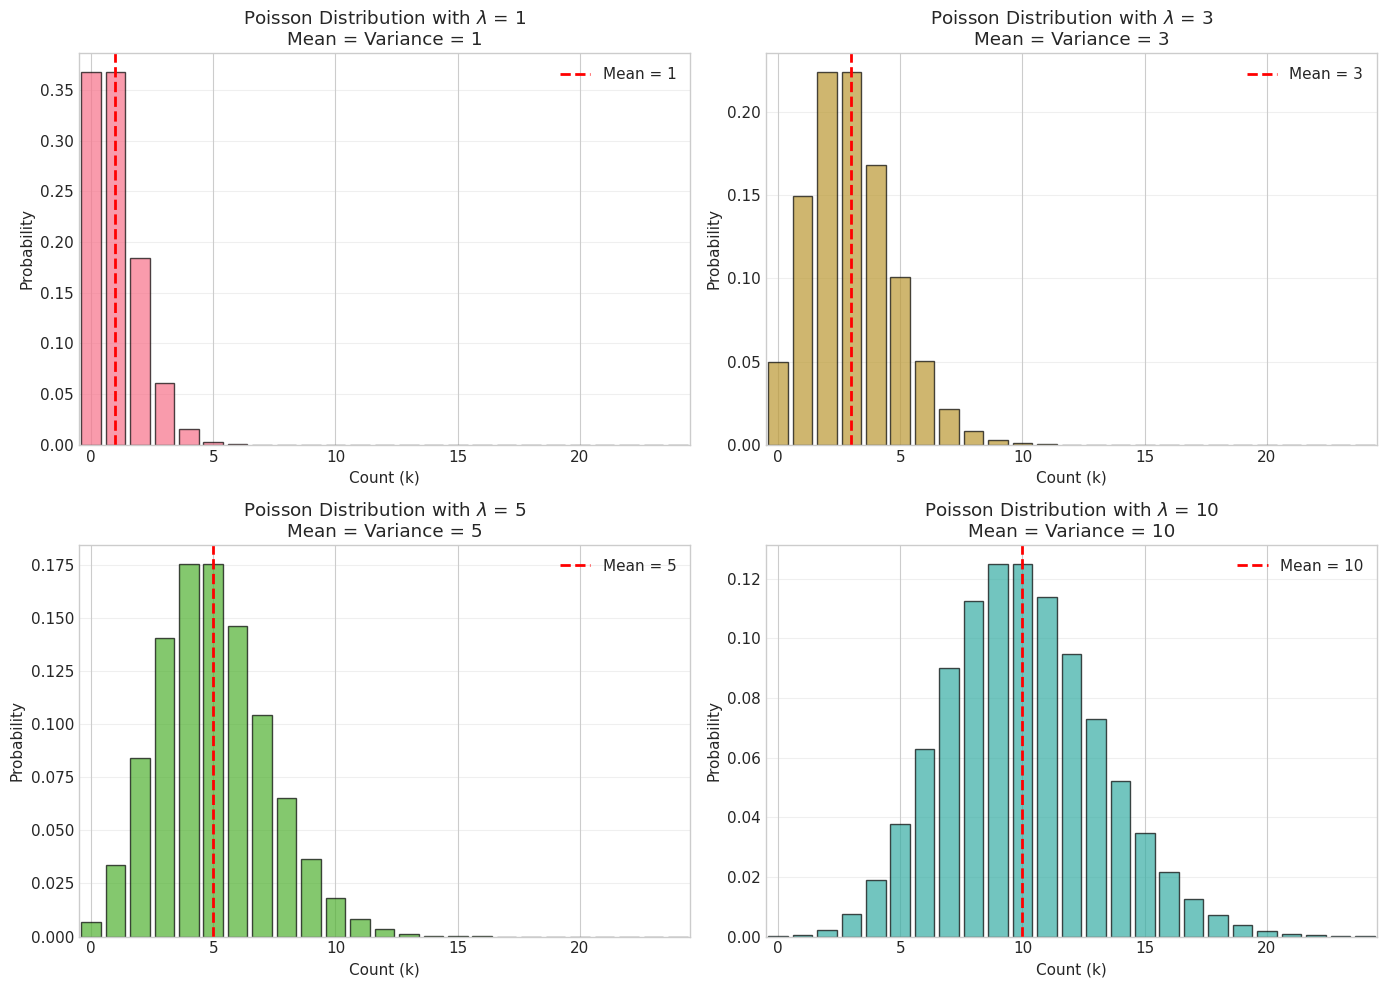

Note: As lambda increases, the distribution becomes more symmetric and bell-shaped.


In [5]:
# Visualize the Poisson PMF for different rate parameters
lambdas = [1, 3, 5, 10]  # Different lambda values to illustrate shape changes
x_range = np.arange(0, 25)  # Support: 0, 1, 2, ..., 24

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, lam in enumerate(lambdas):
    # Compute PMF: P(Y=k) for each k in x_range
    pmf = stats.poisson.pmf(x_range, lam)

    # Bar plot of probabilities (PMF is discrete, so bars not density curve)
    axes[idx].bar(x_range, pmf, alpha=0.7, color=f'C{idx}', edgecolor='black')
    axes[idx].axvline(lam, color='red', linestyle='--', linewidth=2,
                      label=f'Mean = {lam}')
    axes[idx].set_xlabel('Count (k)')
    axes[idx].set_ylabel('Probability')
    axes[idx].set_title(f'Poisson Distribution with $\\lambda$ = {lam}\nMean = Variance = {lam}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3, axis='y')
    axes[idx].set_xlim(-0.5, 24.5)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'poisson_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print('Note: As lambda increases, the distribution becomes more symmetric and bell-shaped.')

*Figure: Four Poisson PMF bar charts for different rate parameters. Top-left: lambda=1 (strongly right-skewed, mode at 0-1). Top-right: lambda=3 (moderately skewed). Bottom-left: lambda=5 (approaching symmetric). Bottom-right: lambda=10 (nearly bell-shaped). Red dashed line marks the mean in each plot, illustrating how the distribution shape changes with lambda.*

In [6]:
# Demonstrate the equidispersion property with simulated Poisson data
np.random.seed(42)
sample_sizes = [100, 500, 1000, 5000]
lambda_true = 4.2  # True rate parameter (close to our data mean)

# For each sample size, draw Poisson random variables and check Var/Mean ratio
results = []
for n in sample_sizes:
    sample = np.random.poisson(lambda_true, size=n)
    results.append({
        'Sample Size': n,
        'Sample Mean': sample.mean(),
        'Sample Variance': sample.var(),
        'Var/Mean Ratio': sample.var() / sample.mean()
    })

# Display results: Var/Mean should be close to 1.0 for true Poisson data
results_df = pd.DataFrame(results)
print('Equidispersion Check: Simulated Poisson Data')
print(f'True lambda = {lambda_true}')
print('=' * 60)
display(results_df)
print('\nFor true Poisson data, Var/Mean ratio = 1.0')

Equidispersion Check: Simulated Poisson Data
True lambda = 4.2


,Sample Size,Sample Mean,Sample Variance,Var/Mean Ratio
0,100,4.2600,4.7124,1.1062
1,500,4.1460,4.2047,1.0142
2,1000,4.1000,3.4720,0.8468
3,5000,4.2144,4.2596,1.0107



For true Poisson data, Var/Mean ratio = 1.0


## 3. Poisson Regression Model

### Model Specification

Poisson regression links the count outcome to covariates through a log link:

$$\log(\lambda_i) = \mathbf{X}_i'\boldsymbol{\beta}$$

Or equivalently (exponential form):

$$\lambda_i = \exp(\mathbf{X}_i'\boldsymbol{\beta})$$

Where:
- $\lambda_i$ is the expected count for observation $i$
- $\mathbf{X}_i$ is the vector of covariates
- $\boldsymbol{\beta}$ is the vector of coefficients

### Why Log Link?

1. **Ensures positive predictions**: $\exp(\cdot) > 0$ always
2. **Multiplicative effects**: Coefficients have multiplicative interpretation
3. **Canonical link**: Natural link for Poisson family (MLE properties)

### Maximum Likelihood Estimation (MLE)

The log-likelihood function:

$$\ell(\boldsymbol{\beta}) = \sum_{i=1}^{N} \left[ y_i \log(\lambda_i) - \lambda_i - \log(y_i!) \right]$$

Maximized numerically using optimization algorithms such as Newton-Raphson or BFGS (Broyden-Fletcher-Goldfarb-Shanno), a quasi-Newton method that approximates the Hessian matrix.

### Model for Healthcare Visits

We'll estimate:

$$\log(\lambda_i) = \beta_0 + \beta_1 \text{age}_i + \beta_2 \text{income}_i + \beta_3 \text{insurance}_i + \beta_4 \text{chronic}_i$$

In [7]:
# Prepare data for PanelBox Poisson model
y = df['visits'].values  # Count outcome variable
X_raw = df[['age', 'income', 'insurance', 'chronic']].values
X = sm.add_constant(X_raw)  # Add intercept (constant) column
var_names = ['const', 'age', 'income', 'insurance', 'chronic']

# Create Poisson model instance
print('Estimating Poisson Regression Model...')
print('=' * 60)

poisson_model = PooledPoisson(
    endog=y,   # Dependent variable (counts)
    exog=X     # Independent variables (with intercept)
)

# Fit via MLE with robust (sandwich) standard errors
# Robust SEs are valid even under mild misspecification
poisson_result = poisson_model.fit(se_type='robust')

# Display model summary: coefficients, SEs, t-stats, p-values
print(poisson_result.summary())

Estimating Poisson Regression Model...

Model Results
Number of Obs: 2000
Number of Parameters: 5

Parameter Estimates:
-------------------
  Param 0: 0.5168 (SE: 0.0385, t: 13.42, p: 0.0000)
  Param 1: 0.0153 (SE: 0.0005, t: 29.33, p: 0.0000)
  Param 2: -0.0022 (SE: 0.0003, t: -6.72, p: 0.0000)
  Param 3: 0.4673 (SE: 0.0249, t: 18.74, p: 0.0000)
  Param 4: 0.8197 (SE: 0.0179, t: 45.92, p: 0.0000)



In [8]:
# Build a detailed coefficient table from the fitted model results
coef_table = pd.DataFrame({
    'Variable': var_names,
    'Coefficient': poisson_result.params,
    'Std. Error': poisson_result.se,
    't-statistic': poisson_result.tvalues,
    'p-value': poisson_result.pvalues,
    'CI Lower': poisson_result.conf_int_lower,   # 95% CI lower bound
    'CI Upper': poisson_result.conf_int_upper,    # 95% CI upper bound
})


def add_stars(p):
    """Convert p-value to significance stars notation.

    Returns '***' for p<0.001, '**' for p<0.01, '*' for p<0.05.
    """
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''


# Add significance indicators to each coefficient
coef_table['Sig'] = coef_table['p-value'].apply(add_stars)

print('Poisson Regression Coefficients')
print('=' * 80)
display(coef_table)
print('\nSignificance: *** p<0.001, ** p<0.01, * p<0.05')

# Save coefficient table to CSV for later reference
coef_table.to_csv(TABLES_DIR / 'table_01_coefficients.csv', index=False)

Poisson Regression Coefficients


,Variable,Coefficient,Std. Error,t-statistic,p-value,CI Lower,CI Upper,Sig
0,const,0.5168,0.0385,13.4189,0.0000e+00,0.4414,0.5923,***
1,age,0.0153,0.0005,29.3265,0.0000e+00,0.0143,0.0163,***
2,income,-0.0022,0.0003,-6.7212,1.8024e-11,-0.0028,-0.0015,***
3,insurance,0.4673,0.0249,18.7432,0.0000e+00,0.4185,0.5162,***
4,chronic,0.8197,0.0179,45.9201,0.0000e+00,0.7848,0.8547,***



Significance: *** p<0.001, ** p<0.01, * p<0.05


## 4. Interpreting Poisson Coefficients

### Semi-Elasticity Interpretation

In the log-linear model, coefficients represent **semi-elasticities**:
- For continuous $X_k$: a one-unit increase in $X_k$ changes $\log(\lambda)$ by $\beta_k$
- Not directly interpretable in terms of counts

### Incidence Rate Ratios (IRR)

**Much more intuitive**: IRR = $\exp(\beta_k)$

#### For Continuous Variables:
- IRR = 1.10 : 10% increase in expected count per unit increase in $X$
- IRR = 0.90 : 10% decrease in expected count per unit increase in $X$
- IRR = 1.00 : no effect

#### For Binary Variables (0/1):
- IRR = 1.50 : group with $X=1$ has 50% more events than group with $X=0$
- IRR = 0.80 : group with $X=1$ has 20% fewer events than group with $X=0$

### Percentage Change Formula

Percentage change = (IRR - 1) x 100%

### Example

If $\beta_{\text{insurance}} = 0.25$:
- IRR = $\exp(0.25) = 1.284$
- Interpretation: Insured individuals have 28.4% more doctor visits than uninsured (all else equal)

In [9]:
# Compute Incidence Rate Ratios (IRR = exp(beta))
# IRR provides multiplicative interpretation: how much the expected count
# changes for a one-unit increase in the covariate
irr_table = coef_table.copy()
irr_table['IRR'] = np.exp(irr_table['Coefficient'])
irr_table['IRR CI Lower'] = np.exp(irr_table['CI Lower'])  # Transform CI bounds too
irr_table['IRR CI Upper'] = np.exp(irr_table['CI Upper'])
irr_table['% Change'] = (irr_table['IRR'] - 1) * 100  # Percentage change interpretation

# Select columns most relevant for interpretation
irr_display = irr_table[['Variable', 'Coefficient', 'IRR', '% Change',
                          'IRR CI Lower', 'IRR CI Upper', 'p-value', 'Sig']]

print('Incidence Rate Ratios (IRR)')
print('=' * 100)
display(irr_display)
print('\nInterpretation:')
print('- IRR > 1: Increase in expected count')
print('- IRR < 1: Decrease in expected count')
print('- IRR = 1: No effect')
print('- % Change = (IRR - 1) x 100%')

# Save IRR table to CSV
irr_display.to_csv(TABLES_DIR / 'table_02_irr.csv', index=False)

Incidence Rate Ratios (IRR)


,Variable,Coefficient,IRR,% Change,IRR CI Lower,IRR CI Upper,p-value,Sig
0,const,0.5168,1.6767,67.6731,1.5548,1.8082,0.0000e+00,***
1,age,0.0153,1.0154,1.5397,1.0144,1.0164,0.0000e+00,***
2,income,-0.0022,0.9979,-0.2149,0.9972,0.9985,1.8024e-11,***
3,insurance,0.4673,1.5958,59.5757,1.5196,1.6757,0.0000e+00,***
4,chronic,0.8197,2.2699,126.9919,2.1919,2.3507,0.0000e+00,***



Interpretation:
- IRR > 1: Increase in expected count
- IRR < 1: Decrease in expected count
- IRR = 1: No effect
- % Change = (IRR - 1) x 100%


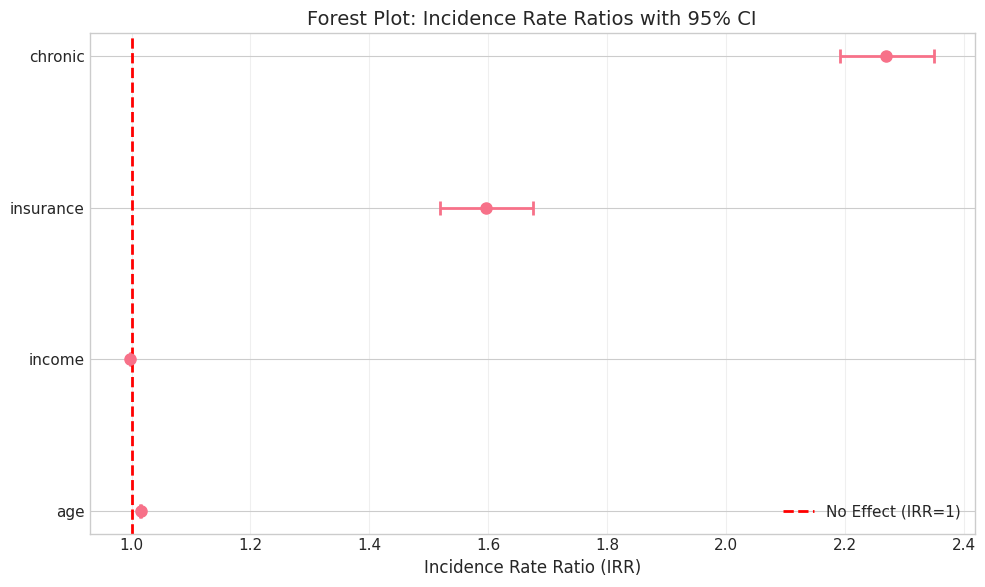

In [10]:
# Create forest plot of IRRs (exclude intercept, which is not meaningful as IRR)
irr_plot_data = irr_display[irr_display['Variable'] != 'const'].copy()
irr_plot_data = irr_plot_data.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each variable's IRR as a point with 95% CI error bars
y_pos = np.arange(len(irr_plot_data))
ax.errorbar(
    irr_plot_data['IRR'],
    y_pos,
    xerr=[
        irr_plot_data['IRR'] - irr_plot_data['IRR CI Lower'],  # Left error
        irr_plot_data['IRR CI Upper'] - irr_plot_data['IRR']   # Right error
    ],
    fmt='o',
    markersize=8,
    capsize=5,
    capthick=2,
    linewidth=2
)

# Reference line at IRR=1 (no effect): CIs crossing this line indicate non-significance
ax.axvline(1, color='red', linestyle='--', linewidth=2, label='No Effect (IRR=1)')

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(irr_plot_data['Variable'])
ax.set_xlabel('Incidence Rate Ratio (IRR)', fontsize=12)
ax.set_title('Forest Plot: Incidence Rate Ratios with 95% CI', fontsize=14)
ax.grid(alpha=0.3, axis='x')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'irr_forest_plot.png', dpi=300, bbox_inches='tight')
plt.show()

*Figure: Forest plot showing Incidence Rate Ratios for age, income, insurance, and chronic condition with 95% confidence intervals. The red dashed vertical line at IRR=1 marks the no-effect threshold. Chronic condition (IRR ~2.27) and insurance (IRR ~1.60) show the largest effects, both well above the no-effect line. Income has IRR slightly below 1, indicating a small negative association.*

### Substantive Interpretation of Results

Based on the IRR estimates above:

- **Age**: Each additional year of age is associated with a ~1.5% increase in expected doctor visits (IRR ~ 1.015). Over a decade, this compounds to roughly 16% more visits.

- **Income**: Each additional $1,000 in income is associated with a ~0.2% decrease in expected visits (IRR ~ 0.998). The effect is statistically significant but small in magnitude.

- **Insurance**: Individuals with health insurance have approximately 60% more expected visits compared to those without insurance (IRR ~ 1.60). This is among the strongest effects in the model.

- **Chronic Condition**: Individuals with a chronic condition have more than double the expected visits compared to those without (IRR ~ 2.27). This is the strongest predictor.

### Policy Implications

- Expanding insurance coverage would significantly increase healthcare utilization
- Chronic disease management programs could help manage high utilization
- Age-related healthcare planning should account for increasing visit rates

## 5. Predictions and Goodness-of-Fit

### Types of Predictions

1. **Expected counts**: $\hat{\lambda}_i = \exp(\mathbf{X}_i'\hat{\boldsymbol{\beta}})$
   - Predicted mean for observation $i$
   - Can be non-integer (expected value)

2. **Predicted probabilities**: $P(Y_i = k | \mathbf{X}_i)$ for specific values of $k$
   - Full probability distribution

### Assessing Fit

Common diagnostics:
- **Deviance**: Measure of discrepancy between observed and fitted
- **Pearson Chi-squared**: Alternative goodness-of-fit statistic
- **Rootogram**: Visual comparison of observed vs expected frequencies
- **Residual analysis**: Check for patterns

In [11]:
# Generate predicted expected counts: lambda_hat = exp(X * beta_hat)
y_pred = poisson_model.predict(type='response')

# Compare actual vs predicted for first 20 observations
comparison_df = pd.DataFrame({
    'Actual': y[:20],
    'Predicted': y_pred[:20],
    'Difference': y[:20] - y_pred[:20]
})

print('Actual vs Predicted Visits (First 20 Observations)')
print('=' * 60)
display(comparison_df)

# Overall goodness-of-fit statistics
print(f'\nOverall Statistics:')
print(f'Mean actual visits: {y.mean():.3f}')
print(f'Mean predicted visits: {y_pred.mean():.3f}')  # Should match for MLE
print(f'Correlation(actual, predicted): {np.corrcoef(y, y_pred)[0,1]:.3f}')

Actual vs Predicted Visits (First 20 Observations)


,Actual,Predicted,Difference
0,4,5.6745,-1.6745
1,4,4.6934,-0.6934
2,5,3.7375,1.2625
3,9,7.4782,1.5218
4,8,4.7944,3.2056
5,1,4.4660,-3.4660
6,5,7.4823,-2.4823
7,19,13.9693,5.0307
8,2,4.0757,-2.0757
9,4,11.8976,-7.8976



Overall Statistics:
Mean actual visits: 6.293
Mean predicted visits: 6.293
Correlation(actual, predicted): 0.784


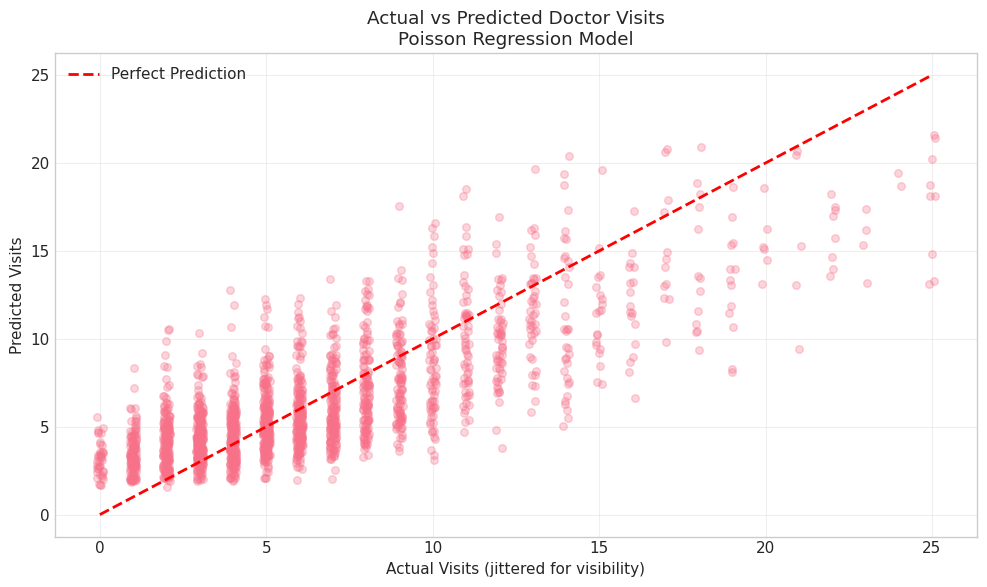

In [12]:
# Scatter plot: Actual vs Predicted counts
fig, ax = plt.subplots(figsize=(10, 6))

# Add small jitter to discrete actual values for visual clarity
np.random.seed(42)  # Reproducible jitter
jitter = 0.1
y_jittered = y + np.random.uniform(-jitter, jitter, size=len(y))

ax.scatter(y_jittered, y_pred, alpha=0.3, s=30)
ax.plot([0, y.max()], [0, y.max()], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('Actual Visits (jittered for visibility)')
ax.set_ylabel('Predicted Visits')
ax.set_title('Actual vs Predicted Doctor Visits\nPoisson Regression Model')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

*Figure: Scatter plot of Poisson model predictions vs actual doctor visits. Points cluster around the 45-degree red dashed line (perfect prediction), indicating reasonable model fit. The spread increases for higher counts, reflecting the heteroskedastic nature of count data. Note: actual values are jittered slightly to avoid overplotting of discrete counts.*

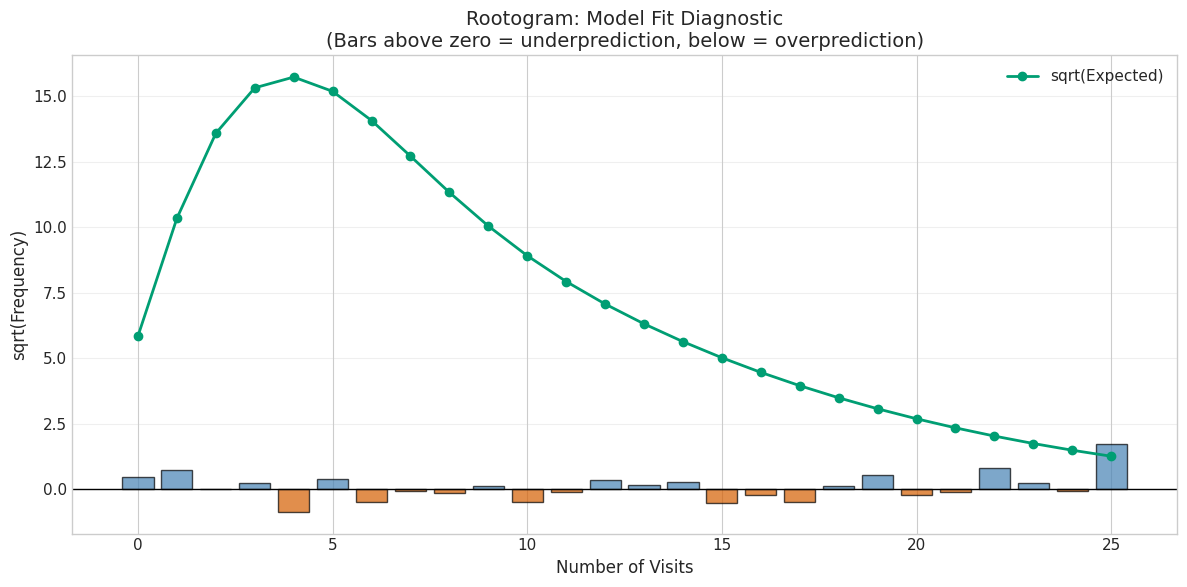

Rootogram interpretation:
- Bars close to zero line indicate good fit
- Bars below zero (orange): model overpredicts that count
- Bars above zero (blue): model underpredicts that count


In [13]:
# Create rootogram: compare observed vs expected frequencies under Poisson model

# Range of count values to evaluate
unique_counts = np.arange(0, y.max() + 1)

# Observed frequency: how many times each count value appears in the data
observed_freq = np.array([(y == k).sum() for k in unique_counts])

# Expected frequency: sum of P(Y=k|lambda_i) across all observations
# Each observation has its own lambda_i, so we sum individual probabilities
expected_freq = np.zeros_like(unique_counts, dtype=float)
for i in range(len(y)):
    lambda_i = y_pred[i]
    for k_idx, k in enumerate(unique_counts):
        expected_freq[k_idx] += stats.poisson.pmf(k, lambda_i)

# Hanging rootogram: bars represent sqrt(observed) - sqrt(expected)
# Positive = model underpredicts, Negative = model overpredicts
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.8
x = unique_counts

hanging = np.sqrt(observed_freq) - np.sqrt(expected_freq)
# Use orange/blue palette (colorblind-friendly) instead of red/green
colors = ['#D55E00' if h < 0 else 'steelblue' for h in hanging]

ax.bar(x, hanging, width=width, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linewidth=1)

# Overlay the expected frequency line for reference
ax.plot(x, np.sqrt(expected_freq), 'o-', color='#009E73', linewidth=2,
        markersize=6, label='sqrt(Expected)')

ax.set_xlabel('Number of Visits', fontsize=12)
ax.set_ylabel('sqrt(Frequency)', fontsize=12)
ax.set_title('Rootogram: Model Fit Diagnostic\n(Bars above zero = underprediction, below = overprediction)',
             fontsize=14)
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'rootogram.png', dpi=300, bbox_inches='tight')
plt.show()

print('Rootogram interpretation:')
print('- Bars close to zero line indicate good fit')
print('- Bars below zero (orange): model overpredicts that count')
print('- Bars above zero (blue): model underpredicts that count')

*Figure: Hanging rootogram comparing observed and expected frequencies under the Poisson model. Blue bars above zero indicate the model underpredicts those counts; orange bars below zero indicate overprediction. The green line shows the square root of expected frequencies. Deviations from zero reveal systematic misfit patterns.*

## 6. Checking the Equidispersion Assumption

### The Equidispersion Problem

Poisson assumes **equidispersion**: $Var[Y|X] = E[Y|X]$

In practice, we often observe **overdispersion**: $Var[Y|X] > E[Y|X]$

### Causes of Overdispersion

1. **Unobserved heterogeneity**: Omitted variables
2. **Clustering**: Groups of correlated observations
3. **Excess zeros or outliers**: More extreme values than Poisson predicts
4. **Misspecification**: Wrong functional form

### Consequences

- Poisson estimates are **still consistent** (correct on average)
- But standard errors are **too small** -> overconfident inference
- **Solution**: Use robust standard errors, or switch to Negative Binomial

### Diagnostic Tests

1. **Overdispersion index**: $Var(Y) / E(Y)$
   - = 1: equidispersion
   - > 1: overdispersion
   - < 1: underdispersion (rare)

2. **Cameron-Trivedi test**: Formal hypothesis test
   - $H_0$: equidispersion
   - $H_1$: overdispersion

In [14]:
# Overdispersion diagnostic: compare unconditional variance to mean
# Under Poisson, Var(Y) should equal E(Y); ratio > 1 indicates overdispersion
sample_mean = y.mean()
sample_var = y.var()
overdispersion_index = sample_var / sample_mean

print('Overdispersion Diagnostic')
print('=' * 60)
print(f'Sample mean: {sample_mean:.3f}')
print(f'Sample variance: {sample_var:.3f}')
print(f'Overdispersion index (Var/Mean): {overdispersion_index:.3f}')
print()

# Interpret the overdispersion index
if overdispersion_index > 1.2:
    print(f'WARNING: Overdispersion detected (index > 1.2)')
    print('   Consider using robust standard errors or Negative Binomial model')
elif overdispersion_index < 0.8:
    print(f'WARNING: Underdispersion detected (index < 0.8)')
    print('   This is unusual; check data quality')
else:
    print('Equidispersion assumption appears reasonable (index ~ 1)')

Overdispersion Diagnostic
Sample mean: 6.293
Sample variance: 19.738
Overdispersion index (Var/Mean): 3.137

   Consider using robust standard errors or Negative Binomial model


In [15]:
# Cameron-Trivedi overdispersion test (formal statistical test)
# Based on auxiliary regression: if Var(Y|X) = mu + alpha*g(mu),
# test H0: alpha = 0 (equidispersion) vs H1: alpha > 0 (overdispersion)

# Step 1: Compute Pearson residuals
pearson_resid = (y - y_pred) / np.sqrt(y_pred)

# Step 2: Construct auxiliary dependent variable
# Under H0, E[(y - lambda)^2 / lambda] = 1
auxiliary_y = ((y - y_pred)**2 / y_pred) - 1

# Step 3: Regress auxiliary_y on predicted lambda
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(y_pred, auxiliary_y)

# Step 4: Test if slope is significantly different from zero
t_stat = slope / std_err

print('Cameron-Trivedi Overdispersion Test')
print('=' * 60)
print('H0: Equidispersion (Var = Mean)')
print('H1: Overdispersion (Var = Mean + alpha x g(Mean))')
print()
print(f'Test statistic: t = {t_stat:.3f}')
print(f'p-value: {p_value:.4f}')
print()

# Interpret the test result
if p_value < 0.05:
    print('Result: Reject H0 (p < 0.05)')
    print('   Evidence of overdispersion')
    print('   Recommendation: Use robust SEs or switch to Negative Binomial')
else:
    print('Result: Fail to reject H0 (p >= 0.05)')
    print('   No strong evidence of overdispersion')
    print('   Poisson model appears appropriate')

Cameron-Trivedi Overdispersion Test
H0: Equidispersion (Var = Mean)
H1: Overdispersion (Var = Mean + alpha x g(Mean))

Test statistic: t = 1.818
p-value: 0.0692

Result: Fail to reject H0 (p >= 0.05)
   No strong evidence of overdispersion
   Poisson model appears appropriate


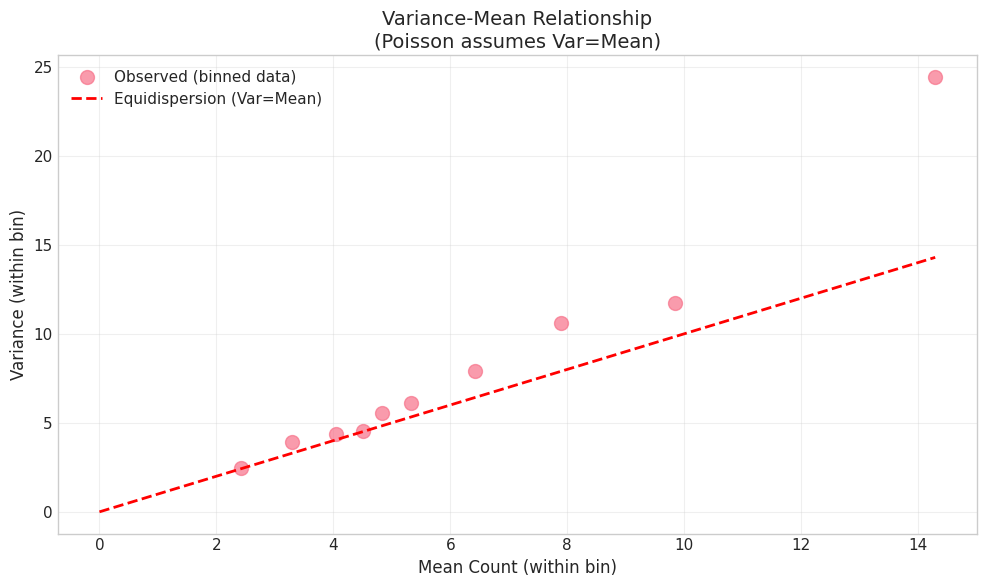

Interpretation:
- Points on the red line: equidispersion
- Points above the line: overdispersion
- Points below the line: underdispersion


In [16]:
# Visualize the variance-mean relationship across prediction bins
# Under Poisson: points should lie on the 45-degree line (Var = Mean)

# Bin observations by predicted lambda into deciles
n_bins = 10
bins = np.percentile(y_pred, np.linspace(0, 100, n_bins + 1))
bin_indices = np.digitize(y_pred, bins) - 1

# Compute mean and variance of actual counts within each bin
bin_means = []
bin_vars = []

for b in range(n_bins):
    mask = bin_indices == b
    if mask.sum() > 5:  # Require at least 5 observations per bin
        bin_means.append(y[mask].mean())
        bin_vars.append(y[mask].var())

bin_means = np.array(bin_means)
bin_vars = np.array(bin_vars)

# Plot: variance vs mean with equidispersion reference line
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(bin_means, bin_vars, s=100, alpha=0.7, label='Observed (binned data)')
ax.plot([0, bin_means.max()], [0, bin_means.max()], 'r--', linewidth=2,
        label='Equidispersion (Var=Mean)')

ax.set_xlabel('Mean Count (within bin)', fontsize=12)
ax.set_ylabel('Variance (within bin)', fontsize=12)
ax.set_title('Variance-Mean Relationship\n(Poisson assumes Var=Mean)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'variance_mean_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print('Interpretation:')
print('- Points on the red line: equidispersion')
print('- Points above the line: overdispersion')
print('- Points below the line: underdispersion')

*Figure: Scatter plot of variance vs mean across decile bins of predicted counts. The red dashed line represents equidispersion (Var=Mean). Points above the line indicate overdispersion. The pattern shows that variance tends to exceed the mean, especially at higher count levels, suggesting the Poisson equidispersion assumption may be violated.*

In [17]:
# Save fitted model results for use in subsequent notebooks
import pickle

results_path = TABLES_DIR / 'poisson_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(poisson_result, f)

print(f'Model results saved to: {results_path}')
print(f'To reload: result = pickle.load(open("{results_path}", "rb"))')

Model results saved to: ../outputs/tables/01_poisson/poisson_results.pkl
To reload: result = pickle.load(open("../outputs/tables/01_poisson/poisson_results.pkl", "rb"))


## Summary and Key Takeaways

### What We Learned

1. **Why Poisson for Counts**
   - OLS is inappropriate: can predict negative values, ignores discreteness
   - Poisson naturally models non-negative integer outcomes
   - Log link ensures positive predictions

2. **Poisson Regression Model**
   - Specification: $\log(\lambda) = \mathbf{X}'\boldsymbol{\beta}$
   - Estimated via maximum likelihood
   - Key assumption: equidispersion (Var = Mean)

3. **Interpretation via IRR**
   - Incidence Rate Ratios: IRR = exp($\beta$)
   - IRR > 1: positive effect (increase in count)
   - IRR < 1: negative effect (decrease in count)
   - Much more intuitive than raw coefficients

4. **Model Assessment**
   - Predictions: expected counts $\hat{\lambda}$
   - Rootogram: visual fit diagnostic
   - Overdispersion check: crucial assumption to verify

5. **Overdispersion**
   - Common in real data (Var > Mean)
   - Test: overdispersion index, Cameron-Trivedi test
   - Solutions: robust SEs, Negative Binomial model

### PanelBox Implementation

```python
from panelbox.models.count import PooledPoisson
import statsmodels.api as sm

# Create model (with intercept)
X = sm.add_constant(X_raw)
model = PooledPoisson(endog=y, exog=X)

# Fit with robust SEs
result = model.fit(se_type='robust')

# Get IRRs
irr = np.exp(result.params)

# Predictions
y_pred = model.predict(type='response')
```

### Next Steps

In the next notebook (**02_negative_binomial.ipynb**), we will:
- Learn how to handle overdispersion formally
- Estimate Negative Binomial models
- Compare Poisson and NB models
- Decide which model is appropriate

### References

- Cameron, A. C., & Trivedi, P. K. (2013). *Regression Analysis of Count Data* (2nd ed.). Cambridge University Press.
- Wooldridge, J. M. (2010). *Econometric Analysis of Cross Section and Panel Data* (2nd ed.). MIT Press.

## Exercises

Try these exercises to reinforce your understanding:

### Exercise 1: Different Specifications
Estimate a Poisson model with:
- Only `age` and `chronic` as predictors
- Add an interaction term: `age x chronic`
- Compare the IRRs with the full model

### Exercise 2: Predictions for Specific Profiles
Calculate expected number of visits for:
- Profile A: age=30, income=40, insurance=1, chronic=0
- Profile B: age=65, income=60, insurance=1, chronic=1
- Profile C: age=25, income=30, insurance=0, chronic=0

Interpret the differences.

### Exercise 3: Test Different Link Functions
While log is canonical, try estimating with:
- Identity link (if available): $\lambda = \mathbf{X}'\boldsymbol{\beta}$
- Compare log-likelihood and predictions

### Exercise 4: Bootstrap Standard Errors
Implement a simple bootstrap to compute standard errors:
- Resample data with replacement 1000 times
- Refit model each time
- Compute bootstrap standard errors
- Compare with analytical robust SEs

In [18]:
# Exercise solutions

# Exercise 1: Different specification
# [Your code here]

# Exercise 2: Predictions for profiles
# [Your code here]

# Exercise 3: Link functions
# [Your code here]

# Exercise 4: Bootstrap
# [Your code here]